# Data Science with Python final project

### Question: How popular will a new track probably be given a selected amount of attributes

Why is this interesting?

When you know how popular a new track will be, you can make better decisions regarding advertisment budgets, cost for the music rights etc.

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob
import json
import sqlite3 as sl
from sqlalchemy import create_engine
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import text
from collections import defaultdict

# Loading Data from DB to DataFrames

#### Tables tracks, lyrics and features provide information about the tracks which could be useful to predict the popularity

In [5]:
engine = create_engine("sqlite:///spotify.db")
tracks_df = pd.read_sql_table("tracks", engine)
lyrics_df = pd.read_sql_table("lyrics", engine)
features_df = pd.read_sql_table("features", engine)

### Check how to do the JOIN

In [6]:
print(f"DataFrame tracks_df has {tracks_df.shape[0]} rows.")
print(f"DataFrame lyrics_df has {lyrics_df.shape[0]} rows.")
print(f"DataFrame features_df has {features_df.shape[0]} rows.")

DataFrame tracks_df has 301508 rows.
DataFrame lyrics_df has 183320 rows.
DataFrame features_df has 301545 rows.


tracks_df and features_df have almost the same amount of rows, but lyrics_df way less
-> check what extra information lyrics_df provides and if we could fill the missing data for the relevant columns

In [7]:
lyrics_df.head()

,uri,title,artist,language,lyrics
0,spotify:track:6Nr3QjImPUhCpUgnykO7hm,Fly In,Lil Wayne,en,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."
1,spotify:track:4P7VFiaZb3xrXoqGwZXC3J,Lollipop Remix,Lil Wayne,en,[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...
2,spotify:track:4T90fwS4tw1Qlxige4a9mK,Lollipop Remix,Lil Wayne,en,[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...
3,spotify:track:0s5bCEmMYwttQIZLHLwOF3,Lollipop Remix,Lil Wayne,en,[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...
4,spotify:track:6Y6f7LSvHxUA61ItYiSMKE,Money On My Mind,Lil Wayne,en,"[Intro]\nYeah\nMoney on my mind, money on my m..."


Only relevant column is the language column, which we could fill up by what other languages the Artist has used

### -> Using OUTERJOIN

In [8]:
df = tracks_df.merge(lyrics_df, how="outer", on="uri")
df = df.merge(features_df, how="outer", on="uri")
df.set_index("uri", inplace=True)

In [9]:
df.head(10)

,type_x,name,duration_ms_x,popularity,explicit,is_local,available_markets,preview_url,disc_number,track_number,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:0ltRc18CGfqQXVoh9HmJEU,track,There'll Come A Day,203213.0,33.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",None,1.0,5.0,...,0.802,0.000000,4.0,0.1930,-4.046,1.0,0.0411,159.017,4.0,0.353
spotify:track:6ZOPMDgEU9gPg0gtlgTc3E,track,Alive,193125.0,17.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",https://p.scdn.co/mp3-preview/ced485344d371879...,1.0,1.0,...,0.830,0.000000,8.0,0.1680,-4.448,0.0,0.0837,127.901,4.0,0.221
spotify:track:28Wu2b54s7TPn0o8xSteeQ,track,Kill Em With Kindness - Felix Cartal Remix,196293.0,0.0,0.0,0.0,,None,1.0,1.0,...,0.774,0.000005,10.0,0.2530,-2.886,0.0,0.0365,121.970,4.0,0.503
spotify:track:20wgVaEsW9ElKWEZkZYOrm,track,Te Vas,169346.0,0.0,0.0,0.0,,None,1.0,10.0,...,0.527,0.000000,5.0,0.1750,-7.995,0.0,0.1090,90.043,4.0,0.492
spotify:track:4AZlgqkThHYfPSstdVuy2f,track,Goin' Back Down,225740.0,0.0,0.0,0.0,,None,1.0,3.0,...,0.877,0.000013,10.0,0.3070,-4.924,0.0,0.1060,170.211,4.0,0.632
spotify:track:16cCeDTKDk4MAMIjhJJMoq,track,Waiting For Your Love,248255.0,12.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",https://p.scdn.co/mp3-preview/e0d2b706435ec324...,1.0,1.0,...,0.766,0.012700,0.0,0.1080,-5.717,1.0,0.0341,121.061,4.0,0.457
spotify:track:23NWg3ow2UrMun7zRXHfce,track,Good Together,195486.0,0.0,0.0,0.0,,None,1.0,1.0,...,0.623,0.000000,1.0,0.4920,-7.006,1.0,0.1050,104.035,4.0,0.495
spotify:track:0Rg6WHOKKrcpVsJeWKmbmZ,track,悪いことばかり学んで,222533.0,5.0,0.0,0.0,JP,https://p.scdn.co/mp3-preview/12c525da8d91f462...,1.0,3.0,...,0.879,0.000000,9.0,0.2720,-2.850,0.0,0.0590,79.997,4.0,0.708
spotify:track:309TfpIu0xvJVFQuYjThq8,track,Drunk,176243.0,0.0,0.0,0.0,,None,1.0,6.0,...,0.302,0.000034,3.0,0.0989,-6.020,1.0,0.0304,87.827,4.0,0.238


# Data Exploration

In [10]:
df.describe()

,duration_ms_x,popularity,explicit,is_local,disc_number,track_number,acousticness,danceability,duration_ms_y,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,3.015080e+05,301508.000000,301508.000000,301508.0,301508.000000,301508.000000,301545.000000,301545.000000,3.015450e+05,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000,301545.000000
mean,2.406148e+05,16.801889,0.122222,0.0,1.033714,6.073889,0.300412,0.564159,2.407267e+05,0.615033,0.146077,5.253063,0.203609,-8.495913,0.659271,0.087874,120.826521,3.905112,0.470279
std,1.110043e+05,18.569157,0.327543,0.0,0.327904,6.150757,0.326362,0.175332,1.102750e+05,0.247393,0.295944,3.571795,0.180150,4.822996,0.473955,0.102617,29.510038,0.416629,0.256793
min,0.000000e+00,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,2.000000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.914660e+05,0.000000,0.000000,0.0,1.000000,2.000000,0.019200,0.450000,1.915300e+05,0.447000,0.000000,2.000000,0.096200,-10.320000,0.000000,0.034800,97.917000,4.000000,0.259000
50%,2.256335e+05,11.000000,0.000000,0.0,1.000000,5.000000,0.152000,0.576000,2.256670e+05,0.653000,0.000069,5.000000,0.127000,-7.272000,1.000000,0.047100,120.050000,4.000000,0.457000
75%,2.694268e+05,31.000000,0.000000,0.0,1.000000,9.000000,0.550000,0.693000,2.694590e+05,0.819000,0.047100,8.000000,0.257000,-5.306000,1.000000,0.088100,139.853000,4.000000,0.674000
max,6.348017e+06,91.000000,1.000000,0.0,43.000000,167.000000,0.996000,0.991000,5.279768e+06,1.000000,1.000000,11.000000,1.000000,3.744000,1.000000,0.965000,247.938000,5.000000,1.000000


In [11]:
#sns.pairplot(df)
#plt.show()

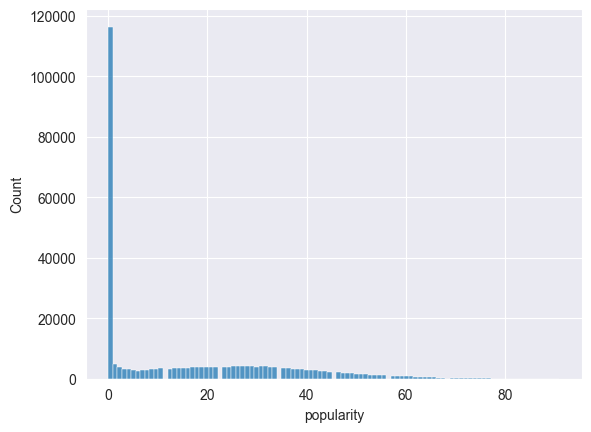

In [12]:
sns.histplot(df["popularity"])
plt.show()

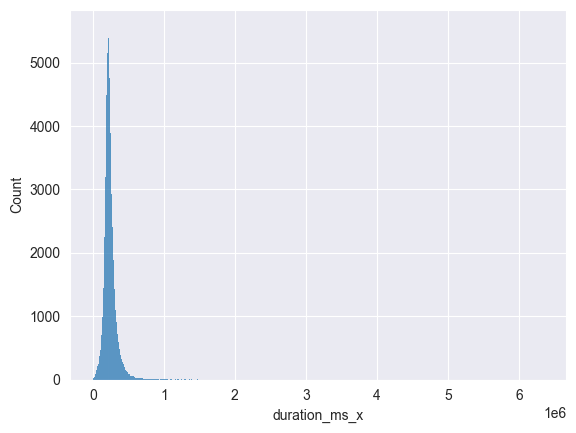

In [13]:
sns.histplot(df["duration_ms_x"])
plt.show()

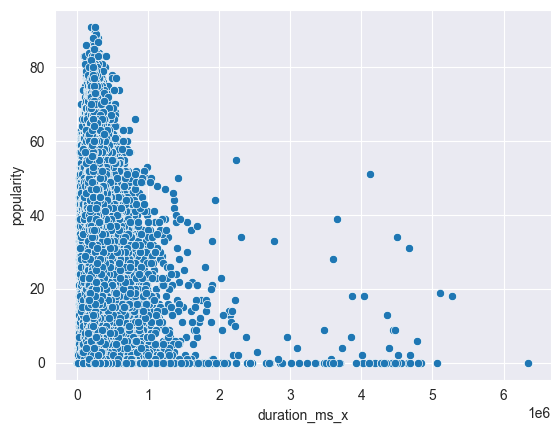

In [14]:
sns.scatterplot(x=df["duration_ms_x"], y=df["popularity"])
plt.show()

# Data transformation

#### Check if we can delete type_x and type_y

In [15]:
df["type_x"].unique()
# the documentation also says it just says the type (track)

array(['track', nan], dtype=object)

In [16]:
df["type_y"].unique()
# the documentation also says it just says the type (track)

array(['audio_features', nan], dtype=object)

-> Only 1 value so no information

In [17]:
del df["type_x"]
del df["type_y"]

### Deleting duplicated columns

##### title and name have the same meaning
-> check which one has more NaN values and delete it

In [18]:
print(f"title has {df['title'].isnull().sum()} NaN values.")
print(f"name has {df['name'].isnull().sum()} NaN values.")

title has 118226 NaN values.
name has 38 NaN values.


In [19]:
del df["title"]

##### Is there a difference between duration_ms_x and duration_ms_y?

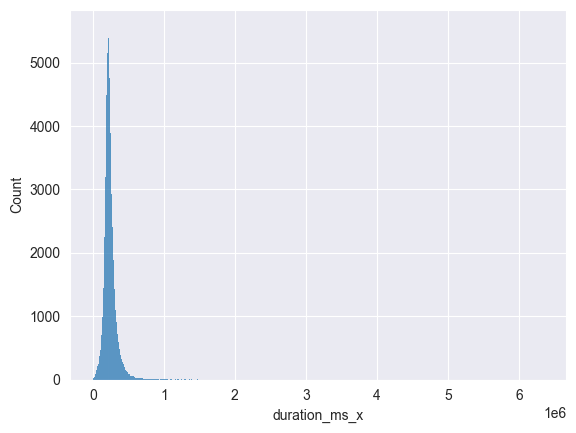

In [20]:
sns.histplot(df["duration_ms_x"])
plt.show()

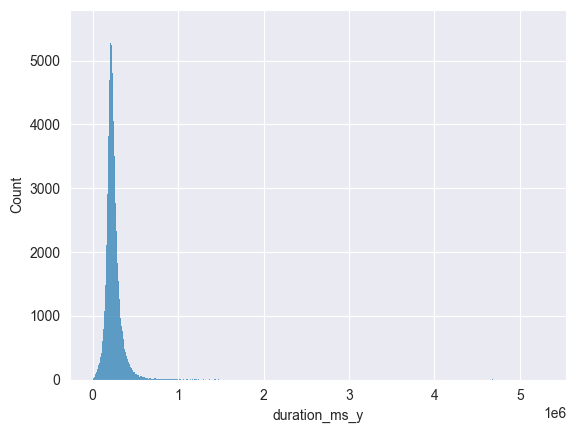

In [21]:
sns.histplot(df["duration_ms_y"])
plt.show()

In [22]:
print(f'{df[df["duration_ms_x"] != df["duration_ms_y"]].shape[0]/df.shape[0]*100//1}% of the tracks have different duration_ms_x than duration_ms_y')

37.0% of the tracks have different duration_ms_x than duration_ms_y


-> From looking at the documentation they are probably the duration from the track and the feature table, so none of them is more credible than the other, so we take the mean

In [23]:
df["duration"] = (df["duration_ms_y"] + df["duration_ms_x"]) / 2

Test if it is the mean

In [24]:
df[["duration_ms_x", "duration_ms_y", "duration"]].sample(10)

,duration_ms_x,duration_ms_y,duration
uri,,,
spotify:track:0ZUTyLMFsDIo2IXym4SQSK,267400.0,267400.0,267400.0
spotify:track:2FXU516iX2gGc35Ry9qtlC,273066.0,273067.0,273066.5
spotify:track:6TiXTCQ2tDBbpDJ6Zvqb5t,195693.0,195693.0,195693.0
spotify:track:1GVSxJSUkp2ytcGMnRs44P,203360.0,203360.0,203360.0
spotify:track:4xjGqrxavGBW8RldcCDBA8,306933.0,306933.0,306933.0
spotify:track:6B0lR3Vzd8ZRAlCr7SdJRH,209333.0,209333.0,209333.0
spotify:track:1Xt8s4grdf0FgEvQ8h8SOg,332746.0,332747.0,332746.5
spotify:track:6xsVTAOZaRpT4DS4dBhvr7,248000.0,248000.0,248000.0
spotify:track:17ribeMLicoXq1CViOl9Bh,189093.0,189093.0,189093.0


In [25]:
del df["duration_ms_y"]
del df["duration_ms_x"]

#### See how many NaNs values each column has

In [26]:
for column in df:
    print(f"{column} has {df[column].isnull().sum()/df.shape[0]*100//1}% NaN values")

name has 0.0% NaN values
popularity has 0.0% NaN values
explicit has 0.0% NaN values
is_local has 0.0% NaN values
available_markets has 0.0% NaN values
preview_url has 50.0% NaN values
disc_number has 0.0% NaN values
track_number has 0.0% NaN values
artist has 39.0% NaN values
language has 40.0% NaN values
lyrics has 39.0% NaN values
acousticness has 0.0% NaN values
danceability has 0.0% NaN values
energy has 0.0% NaN values
instrumentalness has 0.0% NaN values
key has 0.0% NaN values
liveness has 0.0% NaN values
loudness has 0.0% NaN values
mode has 0.0% NaN values
speechiness has 0.0% NaN values
tempo has 0.0% NaN values
time_signature has 0.0% NaN values
valence has 0.0% NaN values
duration has 0.0% NaN values


-> Columns with high number of NaNs: preview_url, artist, language and lyrics

#### Fixing preview_url

There is no relevant information in the preview_url because the only information that could be useful is the ending (.de, .com,...) to see from which country the song is,
but this is already covered by available markets

In [27]:
del df["preview_url"]

#### Fixing language

In [28]:
print(f"{df['language'].isnull().sum()/df.shape[0]*100//1}% of the language entries are NaN.")

40.0% of the language entries are NaN.


##### Can we fill it up over the artist?

In [29]:
print(f'{df[df["language"].isna()]["artist"].isnull().sum()/df["language"].isnull().sum()*100//1}% of the rows with missing language have a missing artist value.')

96.0% of the rows with missing language have a missing artist value.


-> No, that won't be a solution

##### Can we fill it up over the language of the language of the name?

How many and what languages do we have?

In [30]:
languages = df["language"].unique()
print(f"There are {languages.shape[0]} unique languages in the language column.")
print("The Languages are: (language/number of tracks in this language)")
for language in languages:
    print(str(language) + ": " + str(df[df["language"] == language].shape[0]), end=" ")

There are 50 unique languages in the language column.
The Languages are: (language/number of tracks in this language)
nan: 0 en: 163995 ja: 74 pt: 909 None: 0 es: 11155 fil: 379 fr: 836 it: 338 fi: 36 de: 376 ko: 417 is: 39 tr: 123 da: 28 sv: 148 no: 19 uk: 1 hi: 56 ar: 40 ru: 32 ta: 15 he: 41 pl: 18 gl: 1 id: 15 zh: 13 nl: 22 vi: 1 el: 24 fa: 13 la: 6 ro: 6 cy: 2 af: 7 ca: 7 ur: 1 sq: 3 pa: 3 te: 2 ceb: 1 bg: 2 eo: 1 ga: 6 hr: 1 eu: 1 lt: 1 hu: 2 gd: 1 sk: 1 

##### Building classification model to fill up the nan values in the language column

In [31]:
### TODO

##### Check if we can use a language classification model to detect the language from the name

In [32]:
base_options = python.BaseOptions(model_asset_path="language_detector.tflite")
options = text.LanguageDetectorOptions(base_options=base_options)

In [33]:
with python.text.LanguageDetector.create_from_options(options) as detector:
    number_all = df[~df["language"].isnull()].shape[0]
    number_right_detected = 0
    number_not_detected = 0
    for index, row in df[~df["language"].isnull()].iterrows():
        detection_result = detector.detect(str(row["name"]))
        if len(detection_result.detections) > 0 and str(row["language"]) == str(detection_result.detections[0].language_code):
            number_right_detected += 1
        else:
            number_not_detected += 1
    print(f"Number of correct detected languages: {number_right_detected/number_all*100//1} (Precision)")
    print(f"Number of not detected languages: {number_not_detected/number_all*100//1}")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Number of correct detected languages: 85.0 (Precision)
Number of not detected languages: 14.0


In [34]:
with python.text.LanguageDetector.create_from_options(options) as detector:
    i = 0
    for index, row in df[df["language"].isnull()].iterrows():
        detection_result = detector.detect(str(row["name"]))
        if len(detection_result.detections) > 0:
            i += 1
            df.loc[index, "language"] = detection_result.detections[0].language_code
print(f"{df[df['language'].isnull()].shape[0]/ df.shape[0] * 100 // 1}% of the language values are still NaN.")

2.0% of the language values are still NaN.


-> There are no more ways to fill these missing values so we will drop the rows with missing language values

In [35]:
df.dropna(axis=0, subset=["language"], inplace=True)
print(f"{df[df['language'].isnull()].shape[0]} of the language values are still NaN.")

0 of the language values are still NaN.


#### Fixing artist

There is no way to fill the missing values, so we need to delete the entire column because 39% NaNs is very high

In [36]:
del df["artist"]

#### Fixing lyrics

There is no way to fill the missing values, so we need to delete the entire column because 39% NaNs is very high

In [37]:
del df["lyrics"]

#### Control if we handled all NaNs values

In [38]:
for column in df:
    print(f"{column} has {df[column].isnull().sum()} NaN values")

name has 18 NaN values
popularity has 18 NaN values
explicit has 18 NaN values
is_local has 18 NaN values
available_markets has 18 NaN values
disc_number has 18 NaN values
track_number has 18 NaN values
language has 0 NaN values
acousticness has 1 NaN values
danceability has 1 NaN values
energy has 1 NaN values
instrumentalness has 1 NaN values
key has 1 NaN values
liveness has 1 NaN values
loudness has 1 NaN values
mode has 1 NaN values
speechiness has 1 NaN values
tempo has 1 NaN values
time_signature has 1 NaN values
valence has 1 NaN values
duration has 19 NaN values


-> There are still a few NaN values but so few that we can just delete the regarding rows

In [39]:
df.dropna(inplace=True)

In [40]:
for column in df:
    print(f"{column} has {df[column].isnull().sum()} NaN values")

name has 0 NaN values
popularity has 0 NaN values
explicit has 0 NaN values
is_local has 0 NaN values
available_markets has 0 NaN values
disc_number has 0 NaN values
track_number has 0 NaN values
language has 0 NaN values
acousticness has 0 NaN values
danceability has 0 NaN values
energy has 0 NaN values
instrumentalness has 0 NaN values
key has 0 NaN values
liveness has 0 NaN values
loudness has 0 NaN values
mode has 0 NaN values
speechiness has 0 NaN values
tempo has 0 NaN values
time_signature has 0 NaN values
valence has 0 NaN values
duration has 0 NaN values


-> We handled all missing values

#### Saving the DataFrame to save time

In [41]:
df.to_csv("df.csv")

In [4]:
df = pd.read_csv("df.csv")
df.set_index("uri", inplace=True)
print(df.shape)
df.head()

(294932, 21)


,name,popularity,explicit,is_local,available_markets,disc_number,track_number,language,acousticness,danceability,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:0ltRc18CGfqQXVoh9HmJEU,There'll Come A Day,33.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,5.0,en,0.000277,0.356,...,0.000000,4.0,0.193,-4.046,1.0,0.0411,159.017,4.0,0.353,203213.0
spotify:track:6ZOPMDgEU9gPg0gtlgTc3E,Alive,17.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,1.0,en,0.204000,0.503,...,0.000000,8.0,0.168,-4.448,0.0,0.0837,127.901,4.0,0.221,193125.0
spotify:track:28Wu2b54s7TPn0o8xSteeQ,Kill Em With Kindness - Felix Cartal Remix,0.0,0.0,0.0,NaN,1.0,1.0,en,0.004040,0.679,...,0.000005,10.0,0.253,-2.886,0.0,0.0365,121.970,4.0,0.503,196293.0
spotify:track:20wgVaEsW9ElKWEZkZYOrm,Te Vas,0.0,0.0,0.0,NaN,1.0,10.0,es,0.132000,0.830,...,0.000000,5.0,0.175,-7.995,0.0,0.1090,90.043,4.0,0.492,169346.5
spotify:track:4AZlgqkThHYfPSstdVuy2f,Goin' Back Down,0.0,0.0,0.0,NaN,1.0,3.0,en,0.054200,0.518,...,0.000013,10.0,0.307,-4.924,0.0,0.1060,170.211,4.0,0.632,225740.0


### Transform available_markets and language to numerical values

Save information about the most popular languages for later

In [10]:
language_count = df.groupby("language").count()["name"].sort_values(ascending=False)

Check how many unique values there are to decide if we use one-hot-encoding or integer coding

In [43]:
print(f"There are {df['language'].unique().shape[0]} unique languages.")

There are 100 unique languages.


-> We would about 6x the amount of features with one-hot-encoding => Integer Coding

In [44]:
df.language = df.language.astype("category").cat.codes

Test if integer coding was successful

In [45]:
print(f"There are {df['language'].unique().shape[0]} different codes")
df["language"].sample(10)

There are 100 different codes


uri
spotify:track:4aRB62xnctxRdD31TkyQwl    17
spotify:track:6N0AnkdDFZUetw8KAGHV7e    68
spotify:track:76AX8Nnl3mE7vbymRNIvs5    17
spotify:track:35irqidNKuTfXQtwmPEWey    17
spotify:track:6fdiWefYvdnsFxHkDtANVy    17
spotify:track:3N5CB4vma93nYjWWxt8l9K    17
spotify:track:3YRaQGDhuNyOEIS8gjlBZ5    17
spotify:track:11S6IMRsMsqXUMKQCJiJyO    19
spotify:track:5nzIbeoJFhlmvyEP9RV7jJ    17
spotify:track:7EnQcJIOjBUAWZcCfBa13w    19
Name: language, dtype: int8

-> 100 codes for 100 different languages

In [46]:
countries = set()
for index, row in df.iterrows():
    countries.update(set(str(row["available_markets"]).replace(" ", "").split(",")))
print(countries)
print(len(countries))

{'KW', 'PT', 'AD', 'MD', 'TW', 'LS', 'PE', 'CG', 'MV', 'BA', 'EG', 'TR', 'TL', 'CO', 'WS', 'PH', 'SM', 'IN', 'AR', 'DE', 'CW', 'ST', 'DM', 'VE', 'LV', 'BW', 'UG', 'MA', 'PS', 'UY', 'HK', 'GT', 'BH', 'JM', 'SC', 'NG', 'BJ', 'SG', 'BN', 'FI', 'UA', 'PY', 'SI', 'SL', 'VU', 'DK', 'TG', 'AL', 'SB', 'ZA', 'SE', 'SZ', 'CR', 'PK', 'LY', 'BO', 'KZ', 'ZM', 'MH', 'GH', 'GD', 'EE', 'CA', 'GY', 'TV', 'MK', 'MY', 'VN', 'SN', 'LR', 'BI', 'LA', 'MO', 'LC', 'CM', 'NP', 'RW', 'AE', 'DO', 'MU', 'AU', 'HR', 'KI', 'CI', 'NO', 'MW', 'GW', 'VC', 'MG', 'CV', 'DZ', 'GR', 'PW', 'EC', 'GM', 'KG', 'KM', 'NZ', 'LK', 'AG', 'AO', 'HN', 'IQ', 'NE', 'MZ', 'MT', 'LI', 'SA', 'NA', 'JO', 'GQ', 'BZ', 'FM', 'KH', 'BB', 'CD', 'SR', 'RS', 'ES', 'TD', 'QA', 'LT', 'CY', 'MX', 'RO', 'BY', 'BS', 'TT', 'GE', 'TH', 'DJ', 'CL', 'KE', 'MR', 'GB', 'BG', 'UZ', 'LB', 'SV', 'TZ', 'ET', 'XK', 'HT', 'LU', 'nan', 'NI', 'AM', 'ME', 'PL', 'BD', 'OM', 'ML', 'PG', 'JP', 'IL', 'MN', 'IS', 'BE', 'MC', 'SK', 'TN', 'HU', 'NR', 'CH', 'KR', 'TJ', 'G

-> 184 markets ("" is no market)are way too much for one-hot-encoding (around 10x the amount of features) and integer coding is not an option because there are often multiple markets in one row

Further information: The official number of markets for spotify is also 184

#### => Translate the markets in possible hearers (size of country)

-> Are there markets in which all tracks are available?

In [47]:
cut_countries = set()
for index, row in df.iterrows():
    cut_countries = set.intersection(set(str(row["available_markets"]).replace(" ", "").split(",")), cut_countries)
print(f"In {len(cut_countries)} markets every track is available.")

In 0 markets every track is available.


-> No so all are relevant
But there is no specific data about the users per market, only per continent so it is pretty hard to get the number of possible hearers
=> We will just use the number of available markets

In [48]:
for index, row in df.iterrows():
    df.loc[index, "number_availabe_markets"] = len(set(str(row["available_markets"]).replace(" ", "").split(",")))
df.sample(10)

,name,popularity,explicit,is_local,available_markets,disc_number,track_number,language,acousticness,danceability,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:71KQPPYDqcDpzWQ3yqGj1L,Open Heart Surgery,26.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,3.0,17,0.383000,0.771,...,0.0,0.0995,-4.992,1.0,0.0464,114.979,4.0,0.8720,270520.0,184.0
spotify:track:4yL5WpJZmoxAV4udhE55VY,Country Nation,41.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,14.0,17,0.038900,0.387,...,4.0,0.1000,-5.529,1.0,0.0413,177.940,4.0,0.4820,225413.0,184.0
spotify:track:0Oa9Qtd0FuhcmLi3sWTF9F,Papa Don't Preach,45.0,0.0,0.0,"AR, AU, AT, BO, BR, BG, CA, CL, CO, CR, CY, CZ...",1.0,22.0,17,0.553000,0.796,...,5.0,0.0400,-3.523,0.0,0.0326,121.976,4.0,0.9620,269573.0,145.0
spotify:track:5kSwn2CFbvPOQQ62k6BRYR,Mary Ann,0.0,0.0,0.0,NaN,1.0,5.0,17,0.292000,0.622,...,5.0,0.0740,-10.231,0.0,0.0372,133.796,4.0,0.8320,307106.5,1.0
spotify:track:1kthTiNrUFWDDVLxSTnWrZ,Baraja de Oro,0.0,0.0,0.0,NaN,1.0,3.0,19,0.636000,0.450,...,11.0,0.0920,-9.309,1.0,0.0398,177.549,3.0,0.9560,197066.5,1.0
spotify:track:2SXfVFviCQ8Z31KgZX421D,No Revenge,0.0,0.0,0.0,NaN,1.0,1.0,17,0.031200,0.429,...,1.0,0.2280,-6.351,1.0,0.1370,92.073,4.0,0.2520,248255.5,1.0
spotify:track:1m9VqD9SX5HZxPK0WCDNma,Everyone Knows Everyone,0.0,0.0,0.0,NaN,1.0,5.0,17,0.000232,0.575,...,6.0,0.3440,-2.810,0.0,0.0482,130.004,4.0,0.7860,198200.0,1.0
spotify:track:3waCT01fN9y5Fbao9SU5mK,XT,0.0,0.0,0.0,NaN,1.0,18.0,17,0.356000,0.724,...,10.0,0.1010,-8.030,1.0,0.0507,119.014,4.0,0.0875,400800.0,1.0
spotify:track:4xmnFMQ6eTo57KpoW8GzBl,"Shh, Be Still",2.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,5.0,17,0.605000,0.630,...,0.0,0.3040,-11.857,1.0,0.0363,88.025,4.0,0.5140,293333.0,140.0


In [49]:
del df["available_markets"]

In [50]:
df.head(5)

,name,popularity,explicit,is_local,disc_number,track_number,language,acousticness,danceability,energy,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:0ltRc18CGfqQXVoh9HmJEU,There'll Come A Day,33.0,0.0,0.0,1.0,5.0,17,0.000277,0.356,0.802,...,4.0,0.193,-4.046,1.0,0.0411,159.017,4.0,0.353,203213.0,184.0
spotify:track:6ZOPMDgEU9gPg0gtlgTc3E,Alive,17.0,0.0,0.0,1.0,1.0,17,0.204000,0.503,0.830,...,8.0,0.168,-4.448,0.0,0.0837,127.901,4.0,0.221,193125.0,184.0
spotify:track:28Wu2b54s7TPn0o8xSteeQ,Kill Em With Kindness - Felix Cartal Remix,0.0,0.0,0.0,1.0,1.0,17,0.004040,0.679,0.774,...,10.0,0.253,-2.886,0.0,0.0365,121.970,4.0,0.503,196293.0,1.0
spotify:track:20wgVaEsW9ElKWEZkZYOrm,Te Vas,0.0,0.0,0.0,1.0,10.0,19,0.132000,0.830,0.527,...,5.0,0.175,-7.995,0.0,0.1090,90.043,4.0,0.492,169346.5,1.0
spotify:track:4AZlgqkThHYfPSstdVuy2f,Goin' Back Down,0.0,0.0,0.0,1.0,3.0,17,0.054200,0.518,0.877,...,10.0,0.307,-4.924,0.0,0.1060,170.211,4.0,0.632,225740.0,1.0


#### In the documentation stands that tracks will be listed seperated for the single and album version even if they are the same
The URI is also different if the track is a single or in a different album even though it is the same track

In [51]:
print(f"There are {df['name'].nunique()} unique names but overall {df.shape[0]} tracks listed.")

There are 223193 unique names but overall 294932 tracks listed.


#### Merging rows together which refer to the same track
We will use the language, explicit and key features to check if it really the same track because these are most resistant to measurement errors.
Because the formula of the popularity index is unknown, we can not use the sum of both or something like that without risking to hurt the data quality, so we will use the max value.
For available markets and is_local we will also use the max value, for the rest the mean value

In [52]:
aggregate_function = {"popularity": "max", "is_local": "max", "disc_number": "mean", "track_number": "mean", "acousticness": "mean", "danceability": "mean", "energy": "mean", "instrumentalness": "mean", "liveness": "mean", "loudness": "mean", "mode": "mean", "speechiness":"mean", "tempo":"mean", "time_signature": "mean", "valence": "mean", "duration":"mean", "number_availabe_markets": "max", "uri": "first"}
reindexed_df = df.reset_index()
agg_df = reindexed_df.groupby(["name", "language", "explicit", "key"], as_index=True).aggregate(aggregate_function).reset_index()
agg_df.set_index("uri", inplace=True)

In [53]:
# test
print(df.shape, agg_df.shape)
agg_df.head(50)

(294932, 21) (271973, 21)


,name,language,explicit,key,popularity,is_local,disc_number,track_number,acousticness,danceability,...,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:1BOYYOtxjA57QUmNwc1yyv,!Dios Mio! El Diablo Es Muy Picante,19,0.0,9.0,2.0,0.0,1.0,1.0,0.880000,0.3080,...,0.850000,0.4090,-11.463,0.0,0.0402,68.114,4.0,0.0338,125702.0,184.0
spotify:track:6hcxMbNQOOY6mdDpTzxecw,!Me Voy Pal' Pueblo - Live,19,0.0,10.0,20.0,0.0,1.0,7.0,0.512000,0.8120,...,0.545000,0.1030,-4.605,0.0,0.1550,136.317,4.0,0.8140,267840.0,70.0
spotify:track:0OXFi5JzxBHYcEWEJ1I79f,""" Frühlingssinfonie "" , Sinfonie Nr. 1, B-Dur,...",13,0.0,10.0,6.0,0.0,1.0,6.0,0.974000,0.3120,...,0.909000,0.0715,-16.622,1.0,0.0360,130.026,4.0,0.0780,698160.0,184.0
spotify:track:5ekAAj9FA91U5aXFQQHMoz,"""*!*!"" What U Heard",17,1.0,2.0,20.0,0.0,1.0,6.0,0.082100,0.8210,...,0.000000,0.0829,-9.096,0.0,0.1370,104.459,4.0,0.7400,197466.5,182.0
spotify:track:01KHK7KB8elDN6owqYqNmV,"""2014: A Pesach Medley""",82,0.0,6.0,3.0,0.0,1.0,1.0,0.451000,0.4250,...,0.000000,0.3710,-7.925,0.0,0.1040,86.088,4.0,0.4980,321637.0,184.0
spotify:track:54Lm6t48g3nG1NYmBVKCnA,"""40"" - Remastered 2008",17,0.0,8.0,0.0,0.0,1.0,10.0,0.185000,0.3710,...,0.582000,0.1830,-9.315,1.0,0.0307,150.316,4.0,0.3100,157666.5,1.0
spotify:track:25Sd73fleKUVPNqITPZkn1,"""45""",48,0.0,8.0,51.0,0.0,1.0,1.0,0.000696,0.3150,...,0.000000,0.2770,-4.709,1.0,0.1020,178.068,4.0,0.4230,202493.0,2.0
spotify:track:44241N8eadh4VlJAd6kQnN,"""A Beautiful Mine"" - Theme from the Amc Series...",17,0.0,8.0,0.0,0.0,1.0,1.0,0.075800,0.6690,...,0.969000,0.1400,-14.394,1.0,0.0413,114.275,4.0,0.2520,37926.0,1.0
spotify:track:5NCiTuYKMKUZejhGKeZB1b,"""A Lovely Night""",17,0.0,7.0,0.0,0.0,1.0,17.0,0.829000,0.4250,...,0.000000,0.2720,-6.948,1.0,0.1960,202.359,4.0,0.6800,151613.0,1.0


Why is the name column in many rows empty?

In [54]:
df[df["name"] == ""].shape

(0, 21)

-> because there are many tracks with an empty name in the original df, so this not an error, the rest also seems fine, so we can save the changes

In [55]:
df = agg_df
print(f"We eliminated {294932- df.shape[0]} duplicates.")

We eliminated 22959 duplicates.


#### Checking if there are any range violations

In [56]:
df.describe()

,language,explicit,key,popularity,is_local,disc_number,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
count,271973.000000,271973.000000,271973.000000,271973.000000,271973.0,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,2.719730e+05,271973.000000
mean,19.166325,0.129722,5.273189,17.581021,0.0,1.034362,6.093051,0.295846,0.565655,0.619007,0.143510,0.205242,-8.447121,0.656651,0.089572,120.925925,3.906743,0.472753,2.410034e+05,101.309351
std,10.307570,0.335998,3.568001,18.850626,0.0,0.330853,6.083880,0.320600,0.173829,0.243589,0.290474,0.179895,4.757033,0.470218,0.103894,29.097307,0.409100,0.254196,1.109797e+05,88.485756
min,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+03,1.000000
25%,17.000000,0.000000,2.000000,0.000000,0.0,1.000000,2.000000,0.020300,0.453000,0.456000,0.000000,0.097100,-10.221000,0.000000,0.035300,98.270000,4.000000,0.266000,1.920645e+05,1.000000
50%,17.000000,0.000000,5.000000,12.000000,0.0,1.000000,5.000000,0.154000,0.577000,0.656000,0.000084,0.130000,-7.256000,1.000000,0.048100,120.073000,4.000000,0.460000,2.259330e+05,170.000000
75%,17.000000,0.000000,8.000000,32.000000,0.0,1.000000,9.000000,0.530000,0.693000,0.818000,0.052900,0.259000,-5.323000,1.000000,0.091100,139.502000,4.000000,0.673000,2.693730e+05,184.000000
max,99.000000,1.000000,11.000000,91.000000,0.0,43.000000,167.000000,0.996000,0.991000,1.000000,1.000000,1.000000,3.744000,1.000000,0.965000,247.938000,5.000000,1.000000,5.279768e+06,184.000000


-> explicit is 0 or 1 (True or False), no violations

-> key is between 0 and 11 so according to the documentation there are no violations and the key was detected for all tracks

-> popularity is between 0 and 91 what is in the given spectrum of 0 to 100, so no violations

-> is_local is always 0 so always false due to the merging process, so also no violations

-> disc_number is at least 1 as given in the documentation, the max value has no limit since there could be an album with like 100 discs, so also no violations

-> track_number is at least 1 as given in the documentation, the max value has no limit since there could be an album with like 100 tracks, so also no violations

-> acousticness, danceability, energy, instrumentalness, liveness, mode, speechiness and valence reaches from 0 to (nearly) 1 as given in the documentation, so also no violations

-> loudness reaches from -60 (as given in the documentation) up to 3.744 instead of 0 => investigate why

-> tempo reaches from 0 to about 248, since there is no fix range given and 4 beats per seconds are reasonable probably no violations here

-> time_signature ranges from 0 to 5 and not as stated in the documentation from 3 to 7 => violations

-> duration ranges from 2s to 528s => 2s are very short, 528s very long investigate

-> number_available_markets reach from 1 to 184, since there needs to be at least one and can not be more than 184, since spotify only has 184 there are no violations

#### Investigate loudness

There are 95 tracks with loudness over 0.


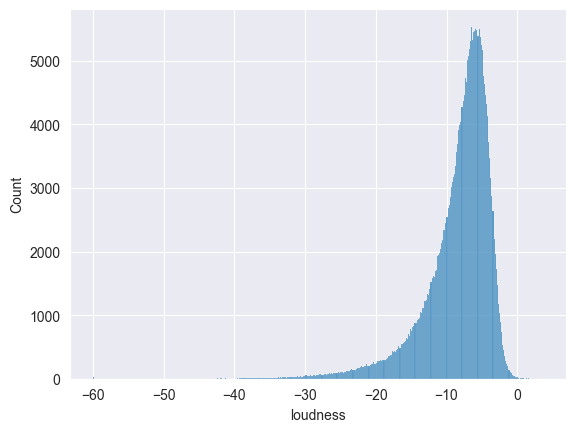

In [57]:
print(f"There are {df[df['loudness'] > 0].shape[0]} tracks with loudness over 0.")
sns.histplot(df["loudness"])
plt.show()

-> Since the loudness is in LUFS and LUFS can not be a positive number since for digital audio 0 is the maximum.
=> Delete rows with loudness over 0.

In [58]:
df = df[df['loudness'] <= 0]
print(f"There are {df[df['loudness'] > 0].shape[0]} tracks with loudness over 0.")

There are 0 tracks with loudness over 0.


#### Fixing time_signature

There are 2399 tracks with time_signature under 3.


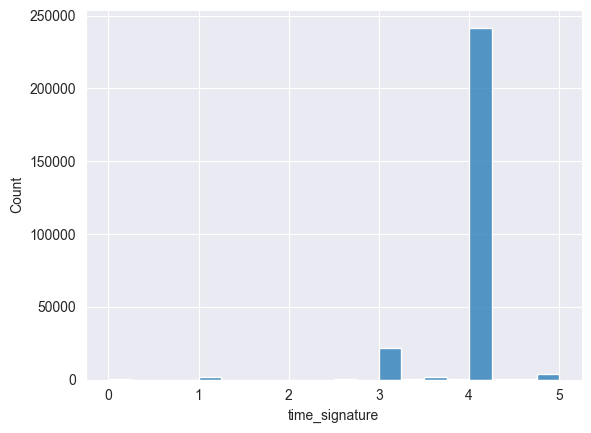

In [59]:
print(f"There are {df[df['time_signature'] < 3].shape[0]} tracks with time_signature under 3.")
sns.histplot(df["time_signature"])
plt.show()

In [60]:
df = df[df['time_signature'] >= 3]
print(f"There are {df[df['time_signature'] < 3].shape[0]} tracks with time_signature under 3.")

There are 0 tracks with time_signature under 3.


#### Investigate duration

In [61]:
df["duration"].describe()

count    2.694790e+05
mean     2.413291e+05
std      1.105503e+05
min      1.500000e+04
25%      1.923595e+05
50%      2.260860e+05
75%      2.695200e+05
max      5.279768e+06
Name: duration, dtype: float64

-> The extreme minimum outliers are already deleted, now the minimum duration is 15 seconds instead of 2s
-> 5270s could be something like a classical song or a mix

In [62]:
df[df["duration"] > 4e+06]

,name,language,explicit,key,popularity,is_local,disc_number,track_number,acousticness,danceability,...,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:5SBLB7hnQGD2pS6CGrpcA7,4x4=12 - Continuous Mix,17,0.0,1.0,0.0,0.0,2.0,1.0,0.000964,0.8090,...,0.199000,0.6210,-7.465,1.0,0.0744,128.065,4.0,0.10100,4195000.0,1.0
spotify:track:1BKPf8dLweDdB0KUAMwjOe,Back On Tracks - CD 1 FULL DJ MIX,17,0.0,7.0,4.0,0.0,1.0,31.0,0.003000,0.7170,...,0.747000,0.1840,-5.688,1.0,0.0614,126.056,4.0,0.24200,4382013.0,184.0
spotify:track:7J1fqAsqbmsWtY24mwNuMR,Back On Tracks 3 - Continuous Mix,17,0.0,1.0,2.0,0.0,1.0,30.0,0.000806,0.7240,...,0.764000,0.1710,-8.458,1.0,0.0588,124.998,4.0,0.28800,4512403.5,184.0
spotify:track:2zu9vmDJVHjYgPRdnFMB9I,Back On Tracks Vol 2 - MIXED CD,17,0.0,7.0,2.0,0.0,1.0,28.0,0.002010,0.7290,...,0.510000,0.8920,-8.620,1.0,0.0526,125.172,4.0,0.40700,4014706.5,184.0
spotify:track:3tJHrKmx1nqvkr0okE1aF5,Balearica 2016 - Chus & Ceballos Mixtape,14,0.0,11.0,13.0,0.0,1.0,25.0,0.004620,0.7280,...,0.803000,0.0902,-7.988,0.0,0.0419,124.050,4.0,0.25500,4355573.5,184.0
spotify:track:6poinNE1MAGvVqEWZEpzye,Blue Marlin Ibiza - Continuous DJ Mix 1,25,0.0,5.0,0.0,0.0,1.0,25.0,0.003640,0.7760,...,0.688000,0.0684,-8.833,0.0,0.0389,123.361,4.0,0.32200,4436000.0,1.0
spotify:track:6XMPs1OglOGSO4tTyEXvhc,Blue Marlin Ibiza - Continuous DJ Mix 2,25,0.0,8.0,0.0,0.0,1.0,26.0,0.019700,0.5390,...,0.483000,0.1410,-7.921,1.0,0.0412,114.740,4.0,0.26200,4316154.5,1.0
spotify:track:6SVEfC03iZiQRulq5Br9mA,Bonobo Late Night Tales Continuous Mix,17,0.0,4.0,0.0,0.0,1.0,1.0,0.529000,0.4070,...,0.097700,0.1990,-11.504,0.0,0.1660,77.929,4.0,0.07830,4497994.0,1.0
spotify:track:6RG1KXreBmvT4P38rLl9Sz,Club Life: Miami - Continuous DJ Mix,17,0.0,11.0,0.0,0.0,1.0,16.0,0.001750,0.6110,...,0.177000,0.0731,-5.644,0.0,0.0478,127.996,4.0,0.16200,4471884.5,1.0


-> mostly mixes and a couple of nature sounds and classical tracks so no violations

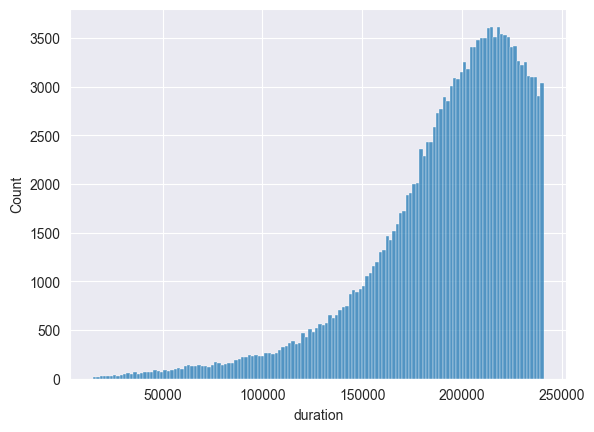

In [63]:
sns.histplot(df[df["duration"] < 2.41e+05]["duration"])
plt.show()

In [64]:
df[df["duration"] < 3e+04].sample(10)

,name,language,explicit,key,popularity,is_local,disc_number,track_number,acousticness,danceability,...,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:29ODSg5mIDmy64Zizx8R4I,Blue Dog (49 Full),17,0.0,8.0,0.0,0.0,1.0,8.0,0.00018,0.260,...,0.988000,0.1190,-14.311,1.0,0.0644,65.922,4.0,0.1930,22689.0,184.0
spotify:track:7dTWkvPOPgbGuMk4HDxNpY,WDPK 83.7 FM,17,0.0,1.0,8.0,0.0,1.0,2.0,0.00492,0.856,...,0.035300,0.4740,-5.916,1.0,0.2060,110.943,4.0,0.9190,28333.0,184.0
spotify:track:4P8MpAqLy5CHZwoYZ0DxrE,Santa Claus Is Coming To Town Intro,17,0.0,1.0,0.0,0.0,1.0,1.0,0.92200,0.126,...,0.783000,0.4450,-13.961,1.0,0.0328,154.385,4.0,0.1610,22906.5,1.0
spotify:track:3U5j59eJpC71UO4M1SbJA5,Safety Blitz (Full),17,0.0,2.0,0.0,0.0,1.0,10.0,0.00112,0.333,...,0.927000,0.0916,-13.866,1.0,0.0544,99.811,3.0,0.4780,22254.5,184.0
spotify:track:39D7fKfpMJVPHw27oizw81,O Come O Come Emmanuel,17,0.0,5.0,0.0,0.0,1.0,1.0,0.39700,0.498,...,0.000000,0.1840,-18.248,1.0,0.0491,107.124,4.0,0.9660,28160.0,1.0
spotify:track:3N74XFs9JWUMOzqQIHnLgX,@electroNOW,17,0.0,4.0,0.0,0.0,1.0,1.0,0.02390,0.487,...,0.000014,0.2040,-4.363,0.0,0.2340,98.624,5.0,0.9210,22334.5,184.0
spotify:track:7MoRsuhIJR435Dqqc41mE8,Quit Your Job,17,0.0,1.0,0.0,0.0,1.0,5.0,0.02510,0.434,...,0.001580,0.1890,-5.497,1.0,0.2180,126.868,4.0,0.6670,25333.0,1.0
spotify:track:3sf2juIAWuVycRPTsroKtX,Up the Middle (Full),17,0.0,7.0,0.0,0.0,1.0,7.0,0.00175,0.460,...,0.000605,0.0935,-14.682,1.0,0.0489,130.416,4.0,0.9210,22429.5,184.0
spotify:track:0jVNv7MUMbdgNT1RluW3RB,One Big Crunch,17,0.0,11.0,0.0,0.0,1.0,11.0,0.98700,0.528,...,0.866000,0.5580,-28.328,0.0,0.1000,38.377,4.0,0.0982,21666.5,184.0


-> Looked the tracks up on spotify and most of them really are that short so no violations

In [65]:
df.to_csv("df2.csv")

In [11]:
df = pd.read_csv("df2.csv")
df.set_index("uri", inplace=True)
print(df.shape)
df.head()

(269479, 21)


,name,language,explicit,key,popularity,is_local,disc_number,track_number,acousticness,danceability,...,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:1BOYYOtxjA57QUmNwc1yyv,!Dios Mio! El Diablo Es Muy Picante,19,0.0,9.0,2.0,0.0,1.0,1.0,0.8800,0.308,...,0.850,0.4090,-11.463,0.0,0.0402,68.114,4.0,0.0338,125702.0,184.0
spotify:track:6hcxMbNQOOY6mdDpTzxecw,!Me Voy Pal' Pueblo - Live,19,0.0,10.0,20.0,0.0,1.0,7.0,0.5120,0.812,...,0.545,0.1030,-4.605,0.0,0.1550,136.317,4.0,0.8140,267840.0,70.0
spotify:track:0OXFi5JzxBHYcEWEJ1I79f,""" Frühlingssinfonie "" , Sinfonie Nr. 1, B-Dur,...",13,0.0,10.0,6.0,0.0,1.0,6.0,0.9740,0.312,...,0.909,0.0715,-16.622,1.0,0.0360,130.026,4.0,0.0780,698160.0,184.0
spotify:track:5ekAAj9FA91U5aXFQQHMoz,"""*!*!"" What U Heard",17,1.0,2.0,20.0,0.0,1.0,6.0,0.0821,0.821,...,0.000,0.0829,-9.096,0.0,0.1370,104.459,4.0,0.7400,197466.5,182.0
spotify:track:01KHK7KB8elDN6owqYqNmV,"""2014: A Pesach Medley""",82,0.0,6.0,3.0,0.0,1.0,1.0,0.4510,0.425,...,0.000,0.3710,-7.925,0.0,0.1040,86.088,4.0,0.4980,321637.0,184.0


#### Handling the unbalance in language (There are some languages in which basically no tracks are written and some in which are many written)

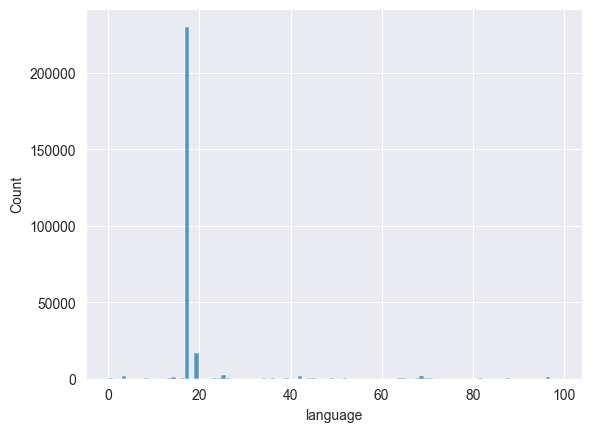

In [12]:
sns.histplot(df["language"], bins=100)
plt.show()

In [15]:
language_count.head()

language
en         253529
es          18010
fr           2854
ar-Latn      2156
it           2132
Name: name, dtype: int64

In [19]:
count_languages = defaultdict(int)
for index, row in df.iterrows():
    count_languages[int(row["language"])] += 1
print(count_languages)
print(f"{round(count_languages[17]/df.shape[0]*100, 2)}% of the tracks are in english.")
print(f"{round(count_languages[19]/df.shape[0]*100, 2)}% of the tracks are in spanish.")

defaultdict(<class 'int'>, {19: 17094, 13: 505, 17: 230072, 82: 568, 48: 141, 3: 2088, 88: 359, 64: 462, 42: 1989, 93: 76, 12: 120, 4: 7, 85: 18, 25: 2752, 65: 361, 1: 66, 36: 233, 26: 238, 31: 111, 8: 309, 30: 54, 0: 163, 34: 697, 70: 628, 54: 57, 52: 673, 39: 279, 69: 1722, 14: 1226, 60: 134, 45: 259, 97: 830, 23: 258, 38: 117, 49: 562, 29: 118, 20: 75, 71: 197, 7: 96, 11: 66, 37: 79, 68: 291, 24: 471, 66: 32, 16: 229, 56: 99, 90: 56, 40: 35, 77: 102, 46: 94, 33: 53, 84: 15, 10: 48, 41: 118, 99: 68, 18: 104, 27: 71, 76: 49, 32: 41, 78: 121, 2: 57, 15: 31, 28: 66, 44: 273, 81: 48, 98: 74, 21: 74, 83: 56, 57: 89, 61: 59, 72: 130, 74: 36, 75: 18, 73: 62, 9: 55, 22: 12, 50: 23, 92: 69, 55: 39, 80: 8, 53: 55, 6: 28, 94: 9, 96: 17, 35: 10, 95: 5, 67: 3, 89: 18, 79: 16, 91: 1, 51: 5, 86: 3, 5: 5, 58: 4, 47: 2, 59: 1, 43: 49, 87: 11, 62: 1, 63: 1})
85.38% of the tracks are in english.
6.34% of the tracks are in spanish.


-> 17 was english, which has way more tracks than all the other languages, 19 was spanish
=> Undersampling for 17 and 19, oversampling for some with very low representation?

-> data of other platforms like YouTube shows that they also have mostly english tracks followed by spanish, but this trend is slowing down, the number of english tracks declines, so we will just undersample english tracks

#### Checking the overweight of non explicit tracks

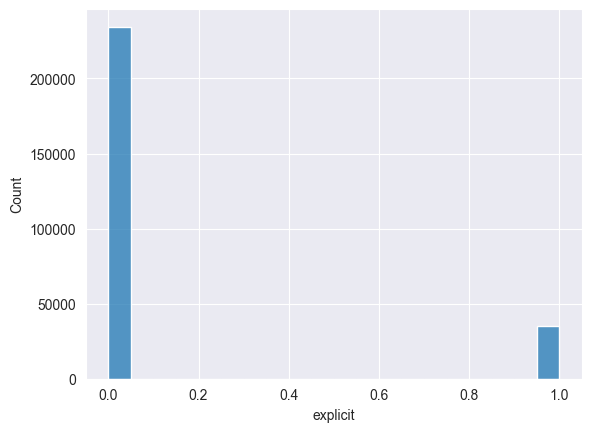

In [16]:
sns.histplot(df["explicit"])
plt.show()

->